<a href="https://colab.research.google.com/github/FYP-CodeByte/ckd-prediction-project/blob/master/preprocessing/Time_series_dataset_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 # Import necessary libraries for data loading and exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive to access the dataset
drive.mount('/content/drive')

# Define the base path
base_path = '/content/drive/My Drive/CKD_Project/data/'

# Load the time series dataset
file_path = base_path + 'Final time series.xlsx'
df_time_series = pd.read_excel(file_path)

# Display basic information about the dataset
print(f"Dataset shape: {df_time_series.shape}")
print(f"Number of patients: {df_time_series['Identifier'].nunique()}")
print("\nFirst 5 rows of the dataset:")
display(df_time_series.head())

# Check the columns in the dataset
print("\nColumns in the dataset:")
print(df_time_series.columns.tolist())

# Check for missing values
missing_values = df_time_series.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)
print(f"Total missing values: {missing_values.sum()}")

# Calculate percentage of missing values per column
missing_percentage = (missing_values / len(df_time_series)) * 100
print("\nPercentage of missing values in each column:")
print(missing_percentage)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (259, 33)
Number of patients: 83

First 5 rows of the dataset:


,Date,Identifier,CREATININE,Gender,Age,eGFR VALUE,HBA1C,SODIUM,POTASSIUM,CLORIDE,...,A/G RATIO,AST,ALT,ALKALINE PHOSPHATASE,GGT,T3,T4,TSH,HEMOGLOBIN,VITAMIN D
0,2020-09-29,1,0.90,M,69,84,7.4,137.0,4.5,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-09-30,1,1.03,M,69,72,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-09-30,1,0.94,M,70,79,8.7,138.0,3.7,97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-06-23,2,1.38,M,53,54,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-07-12,2,1.43,M,53,52,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Columns in the dataset:
['Date', 'Identifier', 'CREATININE', 'Gender', 'Age', 'eGFR VALUE', 'HBA1C', 'SODIUM', 'POTASSIUM', 'CLORIDE', 'TOTAL CHOLES', 'TRIG', 'HDL', 'LDL', 'VLDL', 'T.CHOL/HDL RATIO', 'UREA', 'T.BILI', 'BILI DIRECT', 'BILI INDIRECT', 'TOTAL PROTEIN', 'ALBUMIN', 'GLOBULIN', 'A/G RATIO', 'AST', 'ALT', 'ALKALINE PHOSPHATASE', 'GGT', 'T3', 'T4', 'TSH', 'HEMOGLOBIN', 'VITAMIN D']

Missing values in each column:
Date                      0
Identifier                0
CREATININE               53
Gender                    0
Age                       0
eGFR VALUE              173
HBA1C                   199
SODIUM                  103
POTASSIUM               102
CLORIDE                 104
TOTAL CHOLES            196
TRIG                    205
HDL                     205
LDL                     205
VLDL                    205
T.CHOL/HDL RATIO        205
UREA                    163
T.BILI                  170
BILI DIRECT             171
BILI INDIRECT           171
TOTAL PROTEI

In [ ]:
# Cell 1: Convert Date column and sort data
df_time_series['Date'] = pd.to_datetime(df_time_series['Date'])
df_time_series = df_time_series.sort_values(['Identifier', 'Date'])

# Count observations per patient
patient_counts = df_time_series['Identifier'].value_counts().sort_index()
print("Number of observations per patient:")
print(patient_counts.describe())

Number of observations per patient:
count    83.000000
mean      3.120482
std       2.777951
min       1.000000
25%       1.000000
50%       2.000000
75%       4.000000
max      15.000000
Name: count, dtype: float64


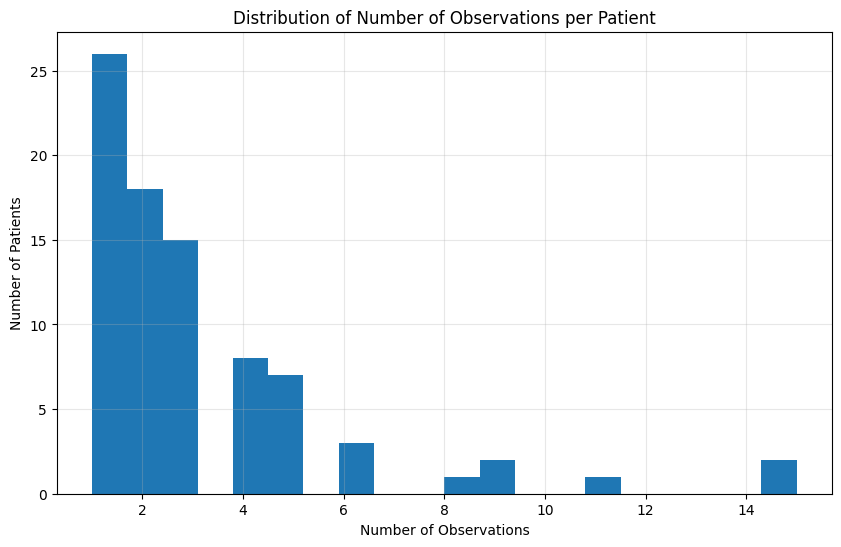

In [ ]:
# Cell 2: Plot the distribution of observations
plt.figure(figsize=(10, 6))
plt.hist(patient_counts, bins=20)
plt.title('Distribution of Number of Observations per Patient')
plt.xlabel('Number of Observations')
plt.ylabel('Number of Patients')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Cell 3: Implement eGFR calculation and CKD staging functions
def calculate_egfr_2021(creatinine, age, is_female):
    """
    Calculate eGFR using 2021 CKD-EPI equation without race
    """
    try:
        # Convert inputs to float
        creatinine = float(creatinine)
        age = float(age)

        # Gender-specific coefficients
        k = 0.7 if is_female else 0.9
        alpha = -0.241 if is_female else -0.302

        # Calculate the terms
        scr_k = creatinine / k

        if scr_k <= 1:
            min_term = scr_k ** alpha
            max_term = 1
        else:
            min_term = 1
            max_term = scr_k ** -1.200

        # Age and gender factors
        age_factor = 0.9938 ** age
        gender_factor = 1.012 if is_female else 1.0

        # Final GFR calculation
        gfr = 142 * min_term * max_term * age_factor * gender_factor
        return gfr
    except (ValueError, TypeError):
        return np.nan

def calculate_row_egfr(row):
    """
    Apply eGFR calculation to a DataFrame row
    """
    is_female = (row['Gender'] == 'F')
    return calculate_egfr_2021(row['CREATININE'], row['Age'], is_female)

def define_ckd_stage(gfr):
    """
    Define CKD stage based on GFR value using standard clinical guidelines
    """
    if pd.isna(gfr):
        return np.nan
    elif gfr >= 90: return 1
    elif gfr >= 60: return 2
    elif gfr >= 30: return 3
    elif gfr >= 15: return 4
    else: return 5

In [ ]:
# Cell 4: Apply eGFR calculation to missing values
# Add calculated eGFR where original is missing but we have creatinine
mask = df_time_series['eGFR VALUE'].isna() & df_time_series['CREATININE'].notna() & df_time_series['Age'].notna() & df_time_series['Gender'].notna()
df_time_series.loc[mask, 'eGFR_calculated'] = df_time_series[mask].apply(calculate_row_egfr, axis=1)

# Check how many eGFR values we were able to calculate
print(f"Missing eGFR values before calculation: {df_time_series['eGFR VALUE'].isna().sum()}")
print(f"eGFR values calculated: {mask.sum()}")
print(f"Remaining missing eGFR values: {df_time_series['eGFR VALUE'].isna().sum() - mask.sum()}")

Missing eGFR values before calculation: 173
eGFR values calculated: 120
Remaining missing eGFR values: 53


In [ ]:
# Cell 5: Validate calculation by comparing with existing values (Fixed version)
# First, check if we have any cases where both original and calculated eGFR exist
validation_mask = df_time_series['eGFR VALUE'].notna() & df_time_series['CREATININE'].notna() & df_time_series['Age'].notna() & df_time_series['Gender'].notna()
valid_count = validation_mask.sum()

print(f"Rows available for validation: {valid_count}")

if valid_count > 0:
    # Calculate eGFR for validation cases
    df_time_series.loc[validation_mask, 'eGFR_validation'] = df_time_series.loc[validation_mask].apply(calculate_row_egfr, axis=1)

    # Convert to numeric to ensure compatibility
    original_values = pd.to_numeric(df_time_series.loc[validation_mask, 'eGFR VALUE'], errors='coerce')
    calculated_values = pd.to_numeric(df_time_series.loc[validation_mask, 'eGFR_validation'], errors='coerce')

    # Drop any NaN values after conversion
    valid_data = pd.DataFrame({'original': original_values, 'calculated': calculated_values}).dropna()

    if len(valid_data) > 0:
        # Calculate correlation and mean absolute error
        correlation = valid_data['original'].corr(valid_data['calculated'])
        mae = (valid_data['original'] - valid_data['calculated']).abs().mean()

        print(f"Validation - Correlation between original and calculated eGFR: {correlation:.4f}")
        print(f"Validation - Mean Absolute Error: {mae:.4f}")

        # Store for plotting
        clean_original = valid_data['original']
        clean_calculated = valid_data['calculated']
    else:
        print("No valid pairs found for correlation after cleaning NaN values")
else:
    print("No rows available for validation")

Rows available for validation: 86
Validation - Correlation between original and calculated eGFR: 0.9971
Validation - Mean Absolute Error: 6.2745


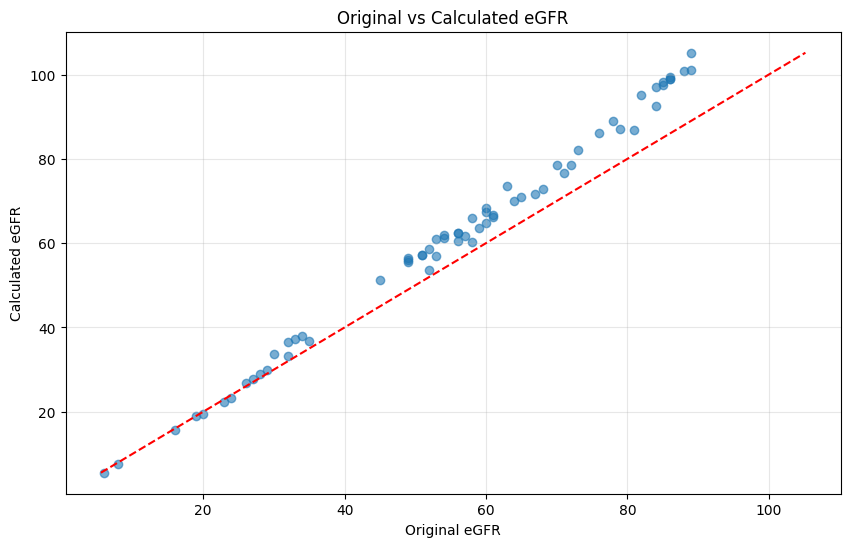

In [ ]:
# Cell 6: Plot comparison if validation was successful
if 'clean_original' in locals() and len(clean_original) > 0:
    plt.figure(figsize=(10, 6))
    plt.scatter(clean_original, clean_calculated, alpha=0.6)
    min_val = min(clean_original.min(), clean_calculated.min())
    max_val = max(clean_original.max(), clean_calculated.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.title('Original vs Calculated eGFR')
    plt.xlabel('Original eGFR')
    plt.ylabel('Calculated eGFR')
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:

# Cell 7: Combine original and calculated eGFR values
# Create a new column that uses the original eGFR when available, otherwise the calculated value
df_time_series['eGFR_combined'] = df_time_series['eGFR VALUE'].fillna(df_time_series['eGFR_calculated'])

# Check how many eGFR values are still missing
missing_egfr = df_time_series['eGFR_combined'].isna().sum()
print(f"eGFR values still missing after calculation: {missing_egfr} ({missing_egfr/len(df_time_series):.2%})")

# Check missingness of key variables
# Added UREA, ALBUMIN, and VITAMIN D to key columns
key_columns = ['Date', 'Identifier', 'CREATININE', 'eGFR_combined', 'HBA1C', 'SODIUM', 'POTASSIUM', 'UREA', 'ALBUMIN', 'VITAMIN D']
missing_data = df_time_series[key_columns].isna().sum()
print("\nMissing values in key columns:")
print(missing_data)

# Display a summary of the dataset
print("\nSummary of key columns with available data:")
summary = df_time_series[key_columns].describe()
print(summary)

eGFR values still missing after calculation: 53 (20.46%)

Missing values in key columns:
Date               0
Identifier         0
CREATININE        53
eGFR_combined     53
HBA1C            199
SODIUM           103
POTASSIUM        102
UREA             163
ALBUMIN          167
VITAMIN D        254
dtype: int64

Summary of key columns with available data:
                                Date  Identifier  CREATININE      HBA1C  \
count                            259  259.000000  206.000000  60.000000   
mean   2021-04-24 23:15:31.274131200   33.138996    1.450146   6.968333   
min              2020-01-01 00:00:00    1.000000    0.330000   4.400000   
25%              2020-07-07 00:00:00   18.000000    0.780000   6.000000   
50%              2020-11-18 00:00:00   31.000000    0.985000   6.850000   
75%              2022-03-08 00:00:00   46.500000    1.427500   7.900000   
max              2024-10-08 00:00:00   83.000000   11.780000   9.500000   
std                              NaN   20.0

Performing final imputation check...
- CREATININE: 0 missing values
- eGFR_combined: 0 missing values
- SODIUM: 0 missing values
- POTASSIUM: 0 missing values
- HBA1C: 0 missing values
- Age: 0 missing values
- UREA: 0 missing values
- ALBUMIN: 0 missing values
- VITAMIN D: 0 missing values
Step 1: Applying time-based interpolation for patients with multiple measurements


<ipython-input-40-de072f3b5d3e>:52: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  temp_values = temp_df[col].interpolate(method='time', limit_direction='both')
<ipython-input-40-de072f3b5d3e>:52: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  temp_values = temp_df[col].interpolate(method='time', limit_direction='both')
<ipython-input-40-de072f3b5d3e>:52: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  temp_values = temp_df[col].interpolate(method='time', limit_direction='both')
<ipython-input-40-de072f3b5d3e>:52: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infe


Missing values after time-based interpolation:
CREATININE: 14/53 remaining (73.6% filled)
eGFR_combined: 53/53 remaining (0.0% filled)
HBA1C: 171/199 remaining (14.1% filled)
SODIUM: 66/103 remaining (35.9% filled)
POTASSIUM: 66/102 remaining (35.3% filled)
UREA: 124/163 remaining (23.9% filled)
ALBUMIN: 135/167 remaining (19.2% filled)
VITAMIN D: 252/254 remaining (0.8% filled)

Step 2: Applying KNN imputation for remaining missing values

Missing values after complete imputation:
CREATININE: 0/53 remaining (100.0% filled)
eGFR_combined: 53/53 remaining (0.0% filled)
HBA1C: 0/199 remaining (100.0% filled)
SODIUM: 0/103 remaining (100.0% filled)
POTASSIUM: 0/102 remaining (100.0% filled)
UREA: 0/163 remaining (100.0% filled)
ALBUMIN: 0/167 remaining (100.0% filled)
VITAMIN D: 0/254 remaining (100.0% filled)


<Figure size 1200x800 with 0 Axes>

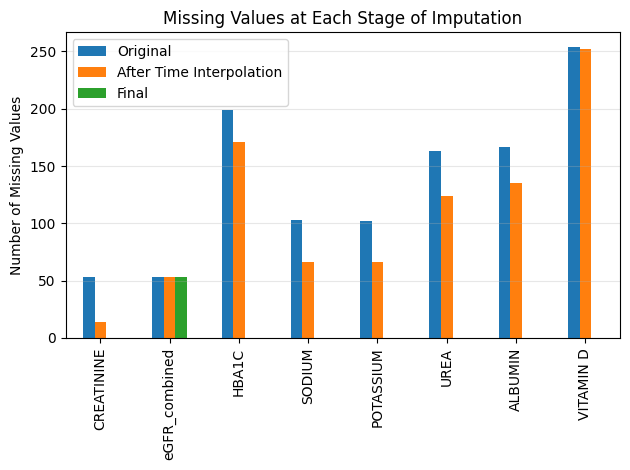

In [ ]:
# Cell 9: Modified hybrid imputation approach
progression_path = base_path + 'timeseries_for_progression.csv'
df_prog = pd.read_csv(progression_path)

# Convert Date column to datetime if needed
df_prog['Date'] = pd.to_datetime(df_prog['Date'])
sequence_features = ['CREATININE', 'eGFR_combined', 'SODIUM', 'POTASSIUM',
                     'HBA1C', 'Age', 'UREA', 'ALBUMIN', 'VITAMIN D']

print("Performing final imputation check...")
for feature in sequence_features:
    if feature in df_prog.columns and df_prog[feature].isna().sum() > 0:
        # Fill any remaining NaNs with feature median
        df_prog[feature] = df_prog[feature].fillna(df_prog[feature].median())

# Verify no NaNs remain
for feature in sequence_features:
    if feature in df_prog.columns:
        print(f"- {feature}: {df_prog[feature].isna().sum()} missing values")

# First, prepare a structure to track imputation success
imputation_stats = {
    'original_missing': {},
    'after_time_interpolation': {},
    'after_full_imputation': {}
}

# Select key columns for focused imputation - added UREA, ALBUMIN, VITAMIN D
focus_columns = ['CREATININE', 'eGFR_combined', 'HBA1C', 'SODIUM', 'POTASSIUM', 'UREA', 'ALBUMIN', 'VITAMIN D']

# Record original missing values
for col in focus_columns:
    imputation_stats['original_missing'][col] = df_time_series[col].isna().sum()

# STEP 1: Time-based interpolation for patients with multiple measurements
print("Step 1: Applying time-based interpolation for patients with multiple measurements")
df_time_imputed = df_time_series.copy()

# Group by patient and apply time interpolation
for patient_id, patient_data in df_time_series.groupby('Identifier'):
    if len(patient_data) >= 2:  # Only for patients with multiple measurements
        # Sort by date
        patient_data = patient_data.sort_values('Date')
        patient_idx = patient_data.index

        # For each column, apply time-based interpolation
        for col in focus_columns:
            if patient_data[col].isna().any() and patient_data[col].notna().sum() >= 2:
                # Set date as index for time-based interpolation
                temp_df = patient_data.set_index('Date')
                # Use time-based interpolation
                temp_values = temp_df[col].interpolate(method='time', limit_direction='both')
                # Update in our imputed dataframe
                df_time_imputed.loc[patient_idx, col] = temp_values.values

# Record missing values after time interpolation
for col in focus_columns:
    imputation_stats['after_time_interpolation'][col] = df_time_imputed[col].isna().sum()

# Display interim results
print("\nMissing values after time-based interpolation:")
for col in focus_columns:
    original = imputation_stats['original_missing'][col]
    after_time = imputation_stats['after_time_interpolation'][col]
    if original > 0:
        success_rate = (original - after_time) / original * 100
    else:
        success_rate = 100
    print(f"{col}: {after_time}/{original} remaining ({success_rate:.1f}% filled)")

# STEP 2: KNN imputation for remaining missing values
print("\nStep 2: Applying KNN imputation for remaining missing values")
from sklearn.impute import KNNImputer

# Prepare data for KNN imputation
# We'll use other available data to inform the imputation
impute_cols = [col for col in df_time_imputed.columns if df_time_imputed[col].dtype in [np.float64, np.int64]
               and col not in ['Year-Month', 'Identifier']]

# Apply KNN imputation to numerical data
imputer = KNNImputer(n_neighbors=5)
imputed_values = imputer.fit_transform(df_time_imputed[impute_cols])
df_fully_imputed = df_time_imputed.copy()
df_fully_imputed[impute_cols] = imputed_values

# Record final missing values
for col in focus_columns:
    imputation_stats['after_full_imputation'][col] = df_fully_imputed[col].isna().sum()

# Display final results
print("\nMissing values after complete imputation:")
for col in focus_columns:
    original = imputation_stats['original_missing'][col]
    after_time = imputation_stats['after_time_interpolation'][col]
    final = imputation_stats['after_full_imputation'][col]
    if original > 0:
        total_success = (original - final) / original * 100
    else:
        total_success = 100
    print(f"{col}: {final}/{original} remaining ({total_success:.1f}% filled)")

# Visualize imputation results
plt.figure(figsize=(12, 8))
stats_df = pd.DataFrame({
    'Original': [imputation_stats['original_missing'][col] for col in focus_columns],
    'After Time Interpolation': [imputation_stats['after_time_interpolation'][col] for col in focus_columns],
    'Final': [imputation_stats['after_full_imputation'][col] for col in focus_columns]
}, index=focus_columns)

stats_df.plot(kind='bar')
plt.title('Missing Values at Each Stage of Imputation')
plt.ylabel('Number of Missing Values')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

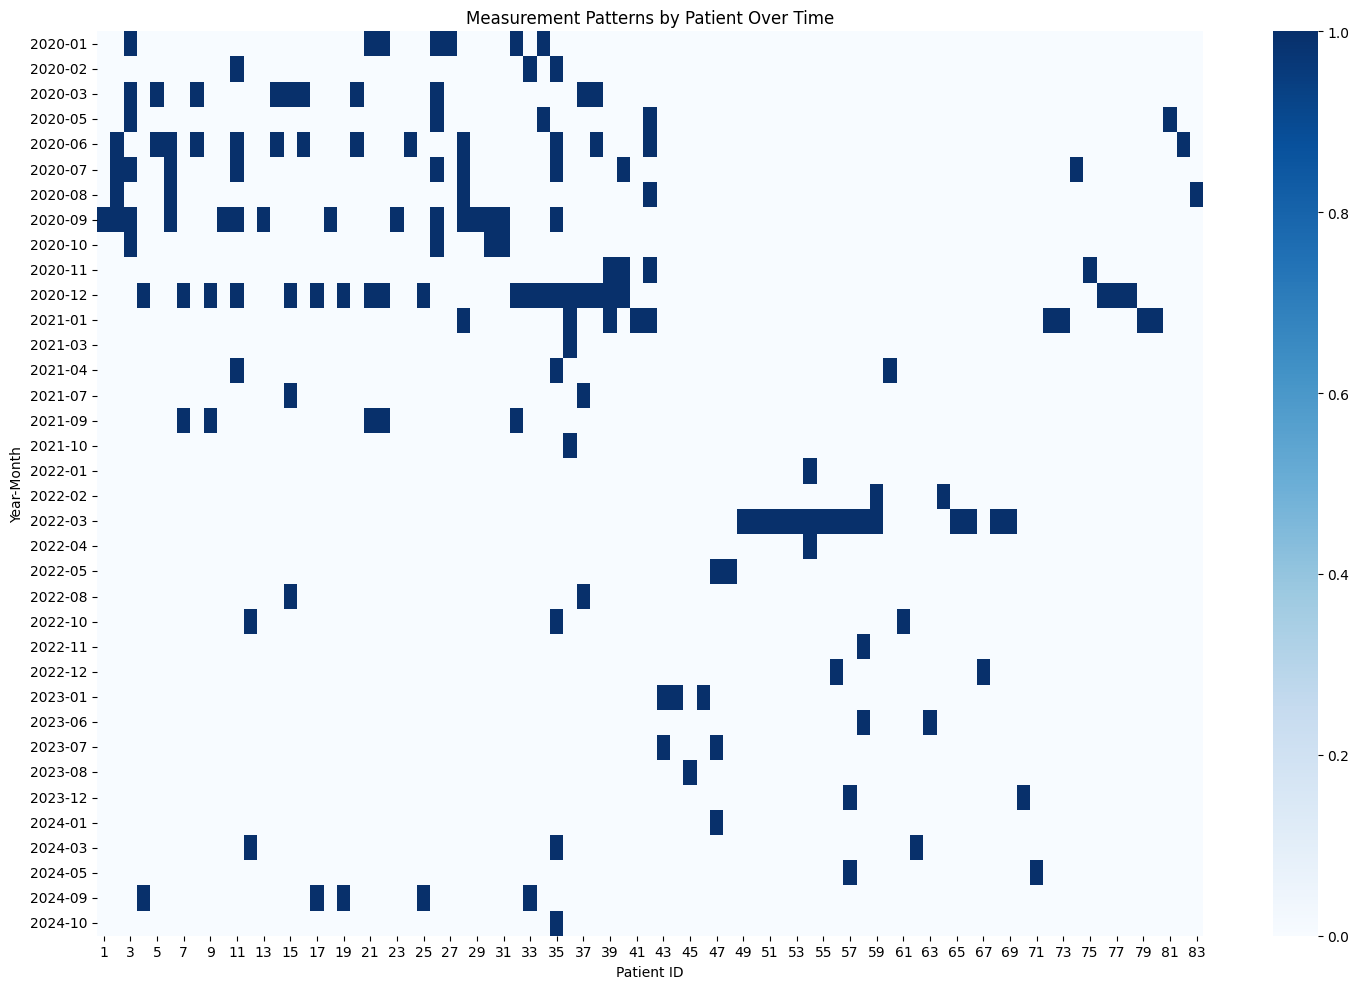


Measurement patterns for top 5 patients with most observations:

Patient 3 - 15 observations:
         Date  CREATININE eGFR_combined  HBA1C  SODIUM  POTASSIUM
7  2020-01-01        0.91            86    NaN   140.0        4.8
8  2020-01-02        0.96            82    NaN   139.0        5.2
9  2020-01-05        0.93            84    NaN     NaN        NaN
10 2020-01-09        0.92            85    8.9     NaN        NaN
11 2020-03-23        0.89            89    NaN     NaN        NaN

Patient 26 - 15 observations:
         Date  CREATININE eGFR_combined  HBA1C  SODIUM  POTASSIUM
86 2020-01-01        0.53     93.434312    NaN   137.0        4.0
87 2020-01-02         NaN           NaN    NaN     NaN        NaN
88 2020-01-05         NaN           NaN    NaN   137.0        3.9
89 2020-01-09         NaN           NaN    NaN     NaN        NaN
90 2020-03-23        1.21     45.306807    NaN   129.0        5.1

Patient 28 - 11 observations:
          Date  CREATININE eGFR_combined  HBA1C  SO

In [ ]:
# Cell 8: Better visualization of patient measurement patterns
# Transpose the pivot table for better visualization
df_time_series['Year-Month'] = df_time_series['Date'].dt.to_period('M')
pivot = pd.crosstab(df_time_series['Year-Month'], df_time_series['Identifier']).fillna(0)
pivot = pivot.astype(bool).astype(int)  # Convert to binary representation

# Better compact visualization
plt.figure(figsize=(15, 10))
sns.heatmap(pivot, cmap='Blues', cbar=True, linewidths=0)
plt.title('Measurement Patterns by Patient Over Time')
plt.xlabel('Patient ID')
plt.ylabel('Year-Month')
plt.tight_layout()
plt.show()

# Examine patterns of variables measured for a few example patients
sample_patients = df_time_series['Identifier'].value_counts().nlargest(5).index.tolist()
print(f"\nMeasurement patterns for top 5 patients with most observations:")
for patient in sample_patients:
    patient_data = df_time_series[df_time_series['Identifier'] == patient].sort_values('Date')
    print(f"\nPatient {patient} - {len(patient_data)} observations:")
    print(patient_data[['Date', 'CREATININE', 'eGFR_combined', 'HBA1C', 'SODIUM', 'POTASSIUM']].head())

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# Load the timeseries_final.csv file
df = pd.read_csv('/content/drive/My Drive/CKD_Project/data/timeseries_final.csv')

    # Calculate eGFR
egfr = calculate_egfr_2021(row['CREATININE'], row['Age'], is_female)

    # Only update if the original is missing or non-numeric
if pd.isna(df.loc[idx, 'eGFR_combined']) or not pd.to_numeric(df.loc[idx, 'eGFR_combined'], errors='coerce'):
        df.loc[idx, 'eGFR_combined'] = egfr

# Convert any string values (like ">90") to numeric
df['eGFR_combined'] = pd.to_numeric(df['eGFR_combined'], errors='coerce')

# Check remaining missing eGFR values
missing_egfr = df['eGFR_combined'].isna().sum()
print(f"Missing eGFR values after calculation: {missing_egfr}")

# Apply KNN imputation for any remaining missing eGFR values
if missing_egfr > 0:
    print(f"Using KNN to impute remaining {missing_egfr} eGFR values")

    # Select numerical columns for imputation
    numerical_cols = ['CREATININE', 'HBA1C', 'SODIUM', 'POTASSIUM', 'Age']
    available_cols = [col for col in numerical_cols if col in df.columns]

    # Add eGFR_combined to the list
    impute_cols = available_cols + ['eGFR_combined']

    # Create imputation dataframe
    impute_data = df[impute_cols].copy()

    # Apply KNN imputation
    imputer = KNNImputer(n_neighbors=3)
    imputed_values = imputer.fit_transform(impute_data)

    # Update only the eGFR_combined column with imputed values
    df.loc[df['eGFR_combined'].isna(), 'eGFR_combined'] = imputed_values[df['eGFR_combined'].isna(), -1]

df['CKD_Stage'] = df['eGFR_combined'].apply(define_ckd_stage)

# Ensure 'Date' column is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Final check for missing values
final_missing = df['eGFR_combined'].isna().sum()
print(f"Final missing eGFR values: {final_missing}")

# Show CKD Stage distribution for all measurements
print("\nCKD Stage distribution (all measurements):")
all_stages = df['CKD_Stage'].value_counts().sort_index()
print(all_stages)
print(f"Total measurements: {len(df)}")

# Show CKD Stage distribution at patient level (using most recent measurement)
most_recent = df.sort_values('Date').groupby('Identifier').last().reset_index()
print("\nCKD Stage distribution (most recent measurement per patient):")
patient_stages = most_recent['CKD_Stage'].value_counts().sort_index()
print(patient_stages)
print(f"Total patients: {len(most_recent)}")

# Save the corrected data
output_path = '/content/drive/My Drive/CKD_Project/data/timeseries_final_corrected.csv'
df.to_csv(output_path, index=False)
print(f"\nSaved corrected data to: {output_path}")

Missing eGFR values after calculation: 74
Using KNN to impute remaining 74 eGFR values
Final missing eGFR values: 0

CKD Stage distribution (all measurements):
CKD_Stage
1     66
2    100
3     60
4     27
5      6
Name: count, dtype: int64
Total measurements: 259

CKD Stage distribution (most recent measurement per patient):
CKD_Stage
1    18
2    26
3    24
4    10
5     5
Name: count, dtype: int64
Total patients: 83

Saved corrected data to: /content/drive/My Drive/CKD_Project/data/timeseries_final_corrected.csv


In [ ]:
df_final_fixed = df_fully_imputed.copy()

# Convert eGFR_combined to numeric before applying the function
df_final_fixed['eGFR_combined'] = pd.to_numeric(df_final_fixed['eGFR_combined'], errors='coerce')

# Apply the function to calculate CKD stages
df_final_fixed['CKD_Stage'] = df_final_fixed['eGFR_combined'].apply(define_ckd_stage)

# Check distribution of CKD stages
stage_counts = df_final_fixed['CKD_Stage'].value_counts().sort_index()
print("\nDistribution of CKD Stages:")
print(stage_counts)
print(f"Stage percentages: {(stage_counts / len(df_final_fixed) * 100).round(1)}")

# Identify patients with CKD progression (eGFR decline over time)
progression_data = []
for patient_id, patient_data in df_final_fixed.groupby('Identifier'):
    if len(patient_data) >= 2:
        # Sort by date
        patient_data = patient_data.sort_values('Date')

        # Calculate eGFR change over time
        first_egfr = patient_data.iloc[0]['eGFR_combined']
        last_egfr = patient_data.iloc[-1]['eGFR_combined']
        time_delta = (patient_data.iloc[-1]['Date'] - patient_data.iloc[0]['Date']).days / 365.25  # In years

        if time_delta > 0.25:  # At least 3 months of follow-up
            # Calculate annualized eGFR slope
            egfr_slope = (last_egfr - first_egfr) / time_delta  # ml/min/year

            # Determine if progression occurred
            # Clinical definition: Decline of >5 ml/min/year or >30% drop
            percent_decline = (first_egfr - last_egfr) / first_egfr * 100
            has_progression = (egfr_slope < -5) or (percent_decline > 30)

            progression_data.append({
                'Identifier': patient_id,
                'First_eGFR': first_egfr,
                'Last_eGFR': last_egfr,
                'Follow_up_years': time_delta,
                'eGFR_slope': egfr_slope,
                'Percent_decline': percent_decline,
                'Has_progression': has_progression
            })

progression_df = pd.DataFrame(progression_data)

# Display summary of progression analysis
if len(progression_df) > 0:
    print(f"\nPatients with sufficient follow-up: {len(progression_df)}")
    print(f"Patients with CKD progression: {progression_df['Has_progression'].sum()} ({progression_df['Has_progression'].mean()*100:.1f}%)")
    print("\nSummary of eGFR slopes (ml/min/year):")
    print(progression_df['eGFR_slope'].describe())

# Save the finalized dataset
output_path = base_path + 'timeseries_final.csv'
df_final_fixed.to_csv(output_path, index=False)
print(f"\nSaved final time series data to: {output_path}")

# Save the progression analysis
if len(progression_df) > 0:
    prog_path = base_path + 'progression_analysis.csv'
    progression_df.to_csv(prog_path, index=False)
    print(f"Saved progression analysis to: {prog_path}")


Distribution of CKD Stages:
CKD_Stage
1.0    47
2.0    63
3.0    43
4.0    26
5.0     6
Name: count, dtype: int64
Stage percentages: CKD_Stage
1.0    18.1
2.0    24.3
3.0    16.6
4.0    10.0
5.0     2.3
Name: count, dtype: float64

Patients with sufficient follow-up: 33
Patients with CKD progression: 5 (15.2%)

Summary of eGFR slopes (ml/min/year):
count    23.000000
mean      0.639077
std      15.515341
min     -51.781092
25%      -3.971673
50%       0.000000
75%       4.477405
max      26.440223
Name: eGFR_slope, dtype: float64

Saved final time series data to: /content/drive/My Drive/CKD_Project/data/timeseries_final.csv
Saved progression analysis to: /content/drive/My Drive/CKD_Project/data/progression_analysis.csv


Cell 12: Finalizing time-series data for progression prediction
Data types of key columns:
CREATININE       float64
eGFR_combined     object
HBA1C            float64
SODIUM           float64
POTASSIUM        float64
UREA             float64
ALBUMIN          float64
VITAMIN D        float64
dtype: object

Verifying data quality:
Total patients: 83
Total observations: 259
Patients with multiple measurements: 57
Progression events detected: 7

CKD Stage distribution:
CKD_Stage
1.0    47
2.0    63
3.0    43
4.0    26
5.0     6
Name: count, dtype: int64

Saved preprocessed time series data to: /content/drive/My Drive/CKD_Project/data/timeseries_for_progression.csv


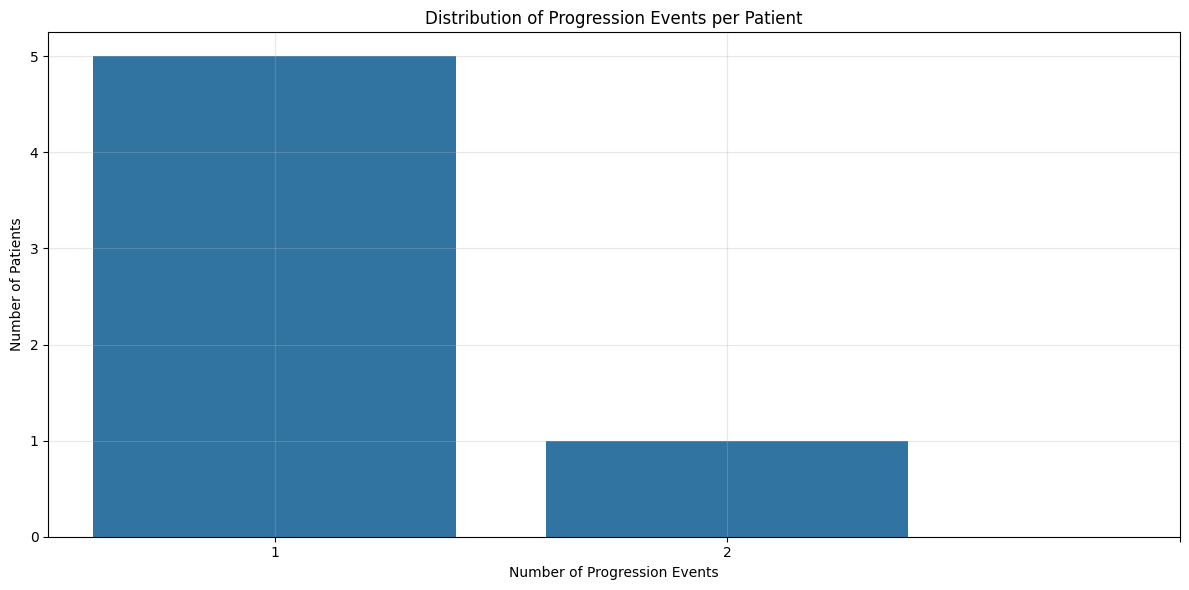

In [ ]:
# Cell 12: Finalize time-series preprocessing for progression prediction
print("Cell 12: Finalizing time-series data for progression prediction")

# 1. Check data types and convert as needed
print("Data types of key columns:")
print(df_fully_imputed[focus_columns].dtypes)

# Create a working copy of the dataset
df_final = df_fully_imputed.copy()

# 2. Convert eGFR_combined to numeric
df_final['eGFR_combined'] = pd.to_numeric(df_final['eGFR_combined'], errors='coerce')

# 3. Ensure date is in datetime format and sort by patient and date
df_final['Date'] = pd.to_datetime(df_final['Date'])
df_final = df_final.sort_values(['Identifier', 'Date'])

# 4. Calculate time deltas and measurement frequencies for each patient
df_final['prev_date'] = df_final.groupby('Identifier')['Date'].shift(1)
df_final['days_since_last'] = (df_final['Date'] - df_final['prev_date']).dt.days

# 5. Calculate changes in key lab values for progression analysis
for col in ['CREATININE', 'eGFR_combined', 'SODIUM', 'POTASSIUM']:
    if col in df_final.columns:
        df_final[f'prev_{col}'] = df_final.groupby('Identifier')[col].shift(1)
        df_final[f'delta_{col}'] = df_final[col] - df_final[f'prev_{col}']

        # Calculate rate of change (per month) for time-dependent modeling
        mask = (df_final['days_since_last'] > 0) & df_final['days_since_last'].notna()
        df_final.loc[mask, f'rate_{col}'] = (
            df_final.loc[mask, f'delta_{col}'] / df_final.loc[mask, 'days_since_last'] * 30
        )

df_final['CKD_Stage'] = df_final['eGFR_combined'].apply(define_ckd_stage)

# 7. Calculate stage transitions for progression events
df_final['prev_stage'] = df_final.groupby('Identifier')['CKD_Stage'].shift(1)
df_final['stage_change'] = df_final['CKD_Stage'] - df_final['prev_stage']
df_final['progression_event'] = (df_final['stage_change'] > 0) & df_final['stage_change'].notna()

# 8. Calculate observation time features for survival analysis
df_final['first_date'] = df_final.groupby('Identifier')['Date'].transform('min')
df_final['observation_time'] = (df_final['Date'] - df_final['first_date']).dt.days

# 9. Create sequence-based features for LSTM
# Number of measurements for each patient
df_final['measurement_count'] = df_final.groupby('Identifier').cumcount() + 1
df_final['total_measurements'] = df_final.groupby('Identifier')['Identifier'].transform('count')

# 10. Verify data quality
print("\nVerifying data quality:")
print(f"Total patients: {df_final['Identifier'].nunique()}")
print(f"Total observations: {len(df_final)}")
print(f"Patients with multiple measurements: {(df_final.groupby('Identifier').size() > 1).sum()}")
print(f"Progression events detected: {df_final['progression_event'].sum()}")

# 11. Summarize CKD stages
stage_counts = df_final['CKD_Stage'].value_counts().sort_index()
print("\nCKD Stage distribution:")
print(stage_counts)

# 12. Save the final preprocessed dataset
output_path = base_path + 'timeseries_for_progression.csv'
df_final.to_csv(output_path, index=False)
print(f"\nSaved preprocessed time series data to: {output_path}")

# 13. Create a visualization of progression events
plt.figure(figsize=(12, 6))
progression_counts = df_final.groupby('Identifier')['progression_event'].sum().reset_index()
progression_counts = progression_counts[progression_counts['progression_event'] > 0]
sns.countplot(x='progression_event', data=progression_counts)
plt.title('Distribution of Progression Events per Patient')
plt.xlabel('Number of Progression Events')
plt.ylabel('Number of Patients')
plt.xticks(range(progression_counts['progression_event'].max() + 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()